<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W2/ungraded_labs/C2_W2_Lab_2_horses_v_humans_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Data Augmentation on the Horses or Humans Dataset

In the previous lab, you saw how data augmentation helped improve the model's performance on unseen data. By tweaking the cat and dog training images, the model was able to learn features that are also representative of the validation data. However, applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results. 

In the next cells, you will apply the same techniques to the `Horses or Humans` dataset and analyze the results.

In [ ]:
# Download the training set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

In [ ]:
# Download the validation set
!wget https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

In [ ]:
# import os
# import zipfile

# # Extract the archive
# zip_ref = zipfile.ZipFile('./horse-or-human.zip', 'r')
# zip_ref.extractall('tmp/horse-or-human')

# zip_ref = zipfile.ZipFile('./validation-horse-or-human.zip', 'r')
# zip_ref.extractall('tmp/validation-horse-or-human')

# zip_ref.close()

# # Directory with training horse pictures
# train_horse_dir = os.path.join('tmp/horse-or-human/horses')

# # Directory with training human pictures
# train_human_dir = os.path.join('tmp/horse-or-human/humans')

# # Directory with validation horse pictures
# validation_horse_dir = os.path.join('tmp/validation-horse-or-human/horses')

# # Directory with validation human pictures
# validation_human_dir = os.path.join('tmp/validation-horse-or-human/humans')

In [7]:
import requests
import zipfile
import os

def get_and_extract_data(url, filename, extract_path):
    """
    Downloads and extracts a ZIP file from a given URL into a specified directory.
    """
    # Ensure the extract_path exists
    os.makedirs(extract_path, exist_ok=True)
    
    # Path to save the downloaded file
    local_zip = os.path.join(extract_path, filename)
    
    # Download the file
    response = requests.get(url)
    with open(local_zip, 'wb') as file:
        file.write(response.content)
    
    # Unzip the dataset into the specified directory
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    
    # Delete zip file
    os.remove(local_zip)
    
    # Check if files are extracted
    print(f"Files extracted to: {os.path.abspath(extract_path)}")

base_path = '../../../data'

# URLs and filenames for the datasets
datasets = [
    ('https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip', 'horse-or-human.zip', 'horse-or-human'),
    ('https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip', 'validation-horse-or-human.zip', 'validation-horse-or-human')
]

# Download and extract each dataset into its respective directory
for url, filename, folder in datasets:
    extract_path = os.path.join(base_path, folder)
    get_and_extract_data(url, filename, extract_path)

# Define the directories for training and validation data
train_horse_dir = os.path.join(base_path, 'horse-or-human/horses')
train_human_dir = os.path.join(base_path, 'horse-or-human/humans')
validation_horse_dir = os.path.join(base_path, 'validation-horse-or-human/horses')
validation_human_dir = os.path.join(base_path, 'validation-horse-or-human/humans')

# Check if directories exist
dirs = [train_horse_dir, train_human_dir, validation_horse_dir, validation_human_dir]
for d in dirs:
    if os.path.exists(d):
        print(f"Directory exists: {d}")
    else:
        print(f"Directory does not exist: {d}")


Files extracted to: c:\wagon\code\tensorflow-1-public\data\horse-or-human
Files extracted to: c:\wagon\code\tensorflow-1-public\data\validation-horse-or-human
Directory exists: ../../../data\horse-or-human/horses
Directory exists: ../../../data\horse-or-human/humans
Directory exists: ../../../data\validation-horse-or-human/horses
Directory exists: ../../../data\validation-horse-or-human/humans


In [9]:
import tensorflow as tf

# Build the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Set training parameters
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        os.path.join(base_path, 'horse-or-human/'),  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        os.path.join(base_path, 'validation-horse-or-human/'),  # This is the source directory for validation images
        target_size=(300, 300),  # All images will be resized to 300x300
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [13]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=EPOCHS,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/20
8/8 [==============================] - 20s 2s/step - loss: 0.6896 - accuracy: 0.5184 - val_loss: 0.6781 - val_accuracy: 0.7969
Epoch 2/20
8/8 [==============================] - 15s 2s/step - loss: 0.6706 - accuracy: 0.6240 - val_loss: 0.6477 - val_accuracy: 0.8828
Epoch 3/20
8/8 [==============================] - 16s 2s/step - loss: 0.6509 - accuracy: 0.6429 - val_loss: 0.7108 - val_accuracy: 0.5000
Epoch 4/20
8/8 [==============================] - 15s 2s/step - loss: 0.6125 - accuracy: 0.7041 - val_loss: 0.5886 - val_accuracy: 0.7188
Epoch 5/20
8/8 [==============================] - 16s 2s/step - loss: 0.5904 - accuracy: 0.7130 - val_loss: 0.6944 - val_accuracy: 0.5234
Epoch 6/20
8/8 [==============================] - 15s 2s/step - loss: 0.5548 - accuracy: 0.7430 - val_loss: 0.6811 - val_accuracy: 0.5469
Epoch 7/20
8/8 [==============================] - 15s 2s/step - loss: 0.5330 - accuracy: 0.7464 - val_loss: 0.9425 - val_accuracy: 0.5039
Epoch 8/20
8/8 [==================

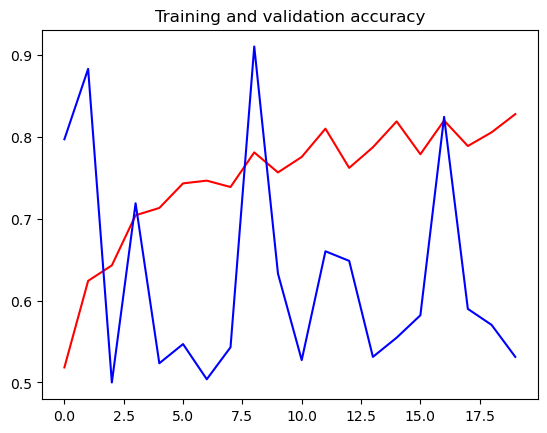

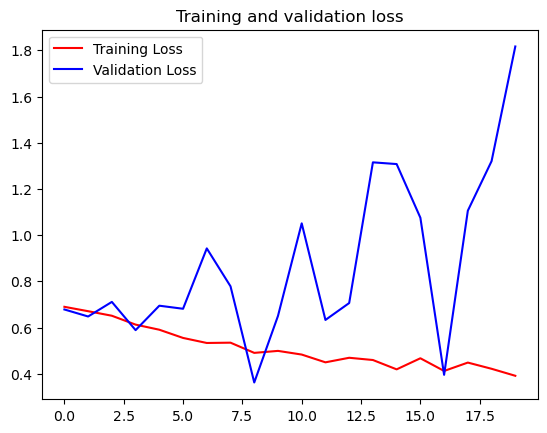

In [14]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data generated still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the image processing techniques that `ImageDataGenerator` provides. It might also be that the background of the training images are also learned so the white background of the validation set is throwing the model off even with cropping. Try looking at the validation images in the `tmp/validation-horse-or-human` directory (note: if you are using Colab, you can use the file explorer on the left to explore the images) and see if you can augment the training images to match its characteristics. If this is not possible, then at this point you can consider other techniques and you will see that in next week's lessons.